The goal of this notebook is to visualize the distributions of infeasible reactions that were synthetically generated from thermodynamically feasible reactions using the alternate reaction center hypothesis. As a reminder, reported reactions were screened for their MDF values using eQuilibrator. Reactions with MDF values above our set threshold were labelled as thermodynamically feasible while those with MDF values below our set threshold were labelled as thermodynamically infeasible. Subsequently, from thermodynamically feasible reactions, negative reactions were strategically inferred.

**0. [Reading in relevant data and defining helper functions](#section_0)**

**1. [Plotting t-SNE visualization of alcohol dehydrogenase product embeddings](#section_1)**

**2. [Visualizing the counts of each type of reaction across all 1224 generalized reaction rules](#section_2)** 

**3. [Manually inspecting the synthetically generated negative reactions](#section_3)** 

In [1]:
import pickle
import pandas as pd
import numpy as np
from typing import Tuple
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.manifold import TSNE
from featurizations import featurizations

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

plt.rcParams['lines.linewidth'] = 2
plt.rcParams['figure.dpi'] = 500 # Resolution of figures
plt.rcParams["figure.autolayout"] = True
plt.rcParams["legend.loc"] = 'best'
plt.rcParams['xtick.labelsize']=18
plt.rcParams['ytick.labelsize']=18

### <a id="section_0"></a>0. Reading in relevant data and defining helper functions

Here, we read in the master reactions dataset of all reactions that fall into one of three categories - (1) thermodynamically feasible reactions, (2) thermodynamically infeasible reactions, and (3) synthetically generated reactions from thermodynamically feasible reactions. We also read in the set of cofactors without their stereochemical information so that for each reaction in our master dataset, we can parse the recorded reaction equation to extract out the relevant substrates, products, and cofactors in this reaction equation.

In [3]:
# Read in .parquet file of all reactions as a pandas dataframe
all_rxns_df = pd.read_parquet('../../data/processed/00_all_rxns_ready_to_fingerprint.parquet')

# Read in cofactors
all_cofactors_wo_stereo_filepath = '../../data/processed/expanded_cofactors_no_stereochem.tsv'
cofactors_df = pd.read_csv(all_cofactors_wo_stereo_filepath, delimiter=',')
all_cofactors_wo_stereo = set(cofactors_df['SMILES'])

In [4]:
def get_rxn_counts(rxns_df: pd.DataFrame, query_rule: str) -> Tuple[int,int,int]:
    """
    Using a pandas dataframe of the reaction dataset and a query rule, this function extracts
    the number of reported reactions mapped to this rule that are thermodynamically feasible and
    infeasible as well as the number of reactions synthetically generated from the feasible set.
    """
    
    relevant_rxns = rxns_df[rxns_df['Rule']==query_rule]
    counts = relevant_rxns['Remarks'].value_counts()
    
    
    try:
        # synthetically generated negative reactions (if present)
        num_generated_neg_rxns = counts['alternate product from pos rxn'] 
    except KeyError:
        num_generated_neg_rxns = 0
    
    try:
        # thermodynamically infeasible reactions (if present)
        num_thermo_infeasible_rxns = counts['neg rxn by thermo'] 
    except KeyError:
        num_thermo_infeasible_rxns = 0
        
    try:
        # thermodynamically feasible reactions (if present)
        num_thermo_feasible_rxns = counts['pos rxn by thermo']
    except KeyError:
        num_thermo_feasible_rxns = 0
    
    return num_generated_neg_rxns, num_thermo_infeasible_rxns, num_thermo_feasible_rxns

In [5]:
def smiles_to_fp(smiles: str, fp_length: int = 2048) -> rdkit.DataStructs.cDataStructs.ExplicitBitVect:
    """
    Generates a morgan/ ecfp4 fingerprint using a SMILES string.
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius = 2, nBits = fp_length)
    else:
        return np.zeros((fp_length,), dtype=int)

In [6]:
def generate_TSNE_embeddings(rxns_df: pd.DataFrame, query_rules: list) -> Tuple[np.ndarray,list]:
    """
    Generates TSNE embeddings of PRODUCTS involved in reactions.
    Using a pandas dataframe of the reaction dataset and a list of query rules, ALL reactions mapped to these
    query rules are first extracted from the pandas dataframe. Subsequently, TSNE embeddings are generated 
    of products involved in these reactions. The generated embeddings are then separated into those belonging
    to produts from thermodynamically feasible reactions, thermodynamically infeasible reactions, and 
    synthetically generated infeasible reactions. We can then visualize the distribution of these three categories
    of products by plotting the first two dimensions of each product's TSNE embeddings on a scatterplot.
    
    Naturally, this technique is most suitable for reactions that generate only one product.
    """
    
    mask = rxns_df['Rule'].isin(query_rules)
    filtered_df = rxns_df[mask]
    reaction_equations = list(filtered_df['Reaction eq'])
    reaction_remarks = list(filtered_df['Remarks'])
    
    # initialize empty list to store the products from all types of reactions enumerated
    all_product_smiles = []
    
    # parse all reactions mapped to the list of query rules to extract the product of each mapped reaction
    for rxn_eq in reaction_equations: 
        rxn_object = featurizations.reaction(rxn_eq)
        
        # the output of this method in the featurizations class is a list so we index 0 to extract the product
        product = rxn_object.get_products(all_cofactors_wo_stereo)[0]
        
        all_product_smiles.append(product)
        
    # each product is then fingerprinted
    fingerprints = np.array([smiles_to_fp(s) for s in all_product_smiles])
    
    # finally, with all fingerprints, the TSNE embeddings are computed
    tsne = TSNE(n_components = 2, random_state = 42)
    reduced_data = tsne.fit_transform(fingerprints)
    
    return reduced_data, reaction_remarks

In [7]:
num_all_thermo_feasible_rxns = all_rxns_df[all_rxns_df['Remarks']=='pos rxn by thermo'].shape[0]
num_all_thermo_infeasible_rxns = all_rxns_df[all_rxns_df['Remarks']=='neg rxn by thermo'].shape[0]
num_all_syn_gen_rxns = all_rxns_df[all_rxns_df['Remarks']=='alternate product from pos rxn'].shape[0]

print(f'\nTotal number of thermodynamically feasible reactions: {num_all_thermo_feasible_rxns}')
print(f'\nTotal number of thermodynamically infeasible reactions: {num_all_thermo_infeasible_rxns}')
print(f'\nTotal number of synthetically generated reactions: {num_all_syn_gen_rxns}')

print(f'\nTotal number of reactions: {all_rxns_df.shape[0]}')


Total number of thermodynamically feasible reactions: 16642

Total number of thermodynamically infeasible reactions: 6161

Total number of synthetically generated reactions: 116412

Total number of reactions: 139215


In [8]:
AdH_rxns_df = all_rxns_df[(all_rxns_df['Rule'] == 'rule0002') | (all_rxns_df['Rule'] == 'rule0003')]

num_all_thermo_feasible_rxns = AdH_rxns_df[AdH_rxns_df['Remarks']=='pos rxn by thermo'].shape[0]
num_all_thermo_infeasible_rxns = AdH_rxns_df[AdH_rxns_df['Remarks']=='neg rxn by thermo'].shape[0]
num_all_syn_gen_rxns = AdH_rxns_df[AdH_rxns_df['Remarks']=='alternate product from pos rxn'].shape[0]

print(f'\nTotal number of thermodynamically feasible alcohol dehydrogenase reactions: {num_all_thermo_feasible_rxns}')
print(f'\nTotal number of thermodynamically infeasible alcohol dehydrogenase reactions: {num_all_thermo_infeasible_rxns}')
print(f'\nTotal number of synthetically generated alcohol dehydrogenase reactions: {num_all_syn_gen_rxns}')

print(f'\nTotal number of alcohol dehydrogenase reactions: {AdH_rxns_df.shape[0]}')


Total number of thermodynamically feasible alcohol dehydrogenase reactions: 1254

Total number of thermodynamically infeasible alcohol dehydrogenase reactions: 686

Total number of synthetically generated alcohol dehydrogenase reactions: 1073

Total number of alcohol dehydrogenase reactions: 3013


### <a id="section_1"></a>1. Plotting t-SNE visualization of alcohol dehydrogenase product embeddings

With all of the data loaded and helper functions defined above, we generate t-SNE embeddings of alcohol dehydrogenase products only in this section. A dimensionality reduction technique, such as t-SNE, will enable us to visualize the chemical space of fingerprinted (via ECFP4) alcohol dehydrogenase products. We chose to use t-SNE as opposed to other dimensionality reduction techniques, such as PCA and UMAP, because t-SNE is best able to capture variations in input data at lower dimensions. PCA and UMAP do not necessarily preseve the fidelity of the data at lower dimensions.

In [9]:
product_embeddings, reaction_remarks = generate_TSNE_embeddings(all_rxns_df,['rule0002','rule0003'])

In [10]:
# Convert reaction remarks to a numeric format given they're categorical for color coding
unique_labels = np.unique(reaction_remarks)
label_to_int = {label: i for i, label in enumerate(unique_labels)}
int_labels = [label_to_int[label] for label in reaction_remarks]

The `unique_labels` printed here in shorthand will be written out more fully for the plot legend

In [11]:
unique_labels

array(['alternate product from pos rxn', 'neg rxn by thermo',
       'pos rxn by thermo'], dtype='<U30')

In plotting this t-SNE visualization, we chose not to apply any scaling, such as min-max scaling or a z-score normalization to restrict the embeddings to -1 to 1 on each axis because such scalings may affect the interpretability of the plot in terms of the relative density and spacing of points.

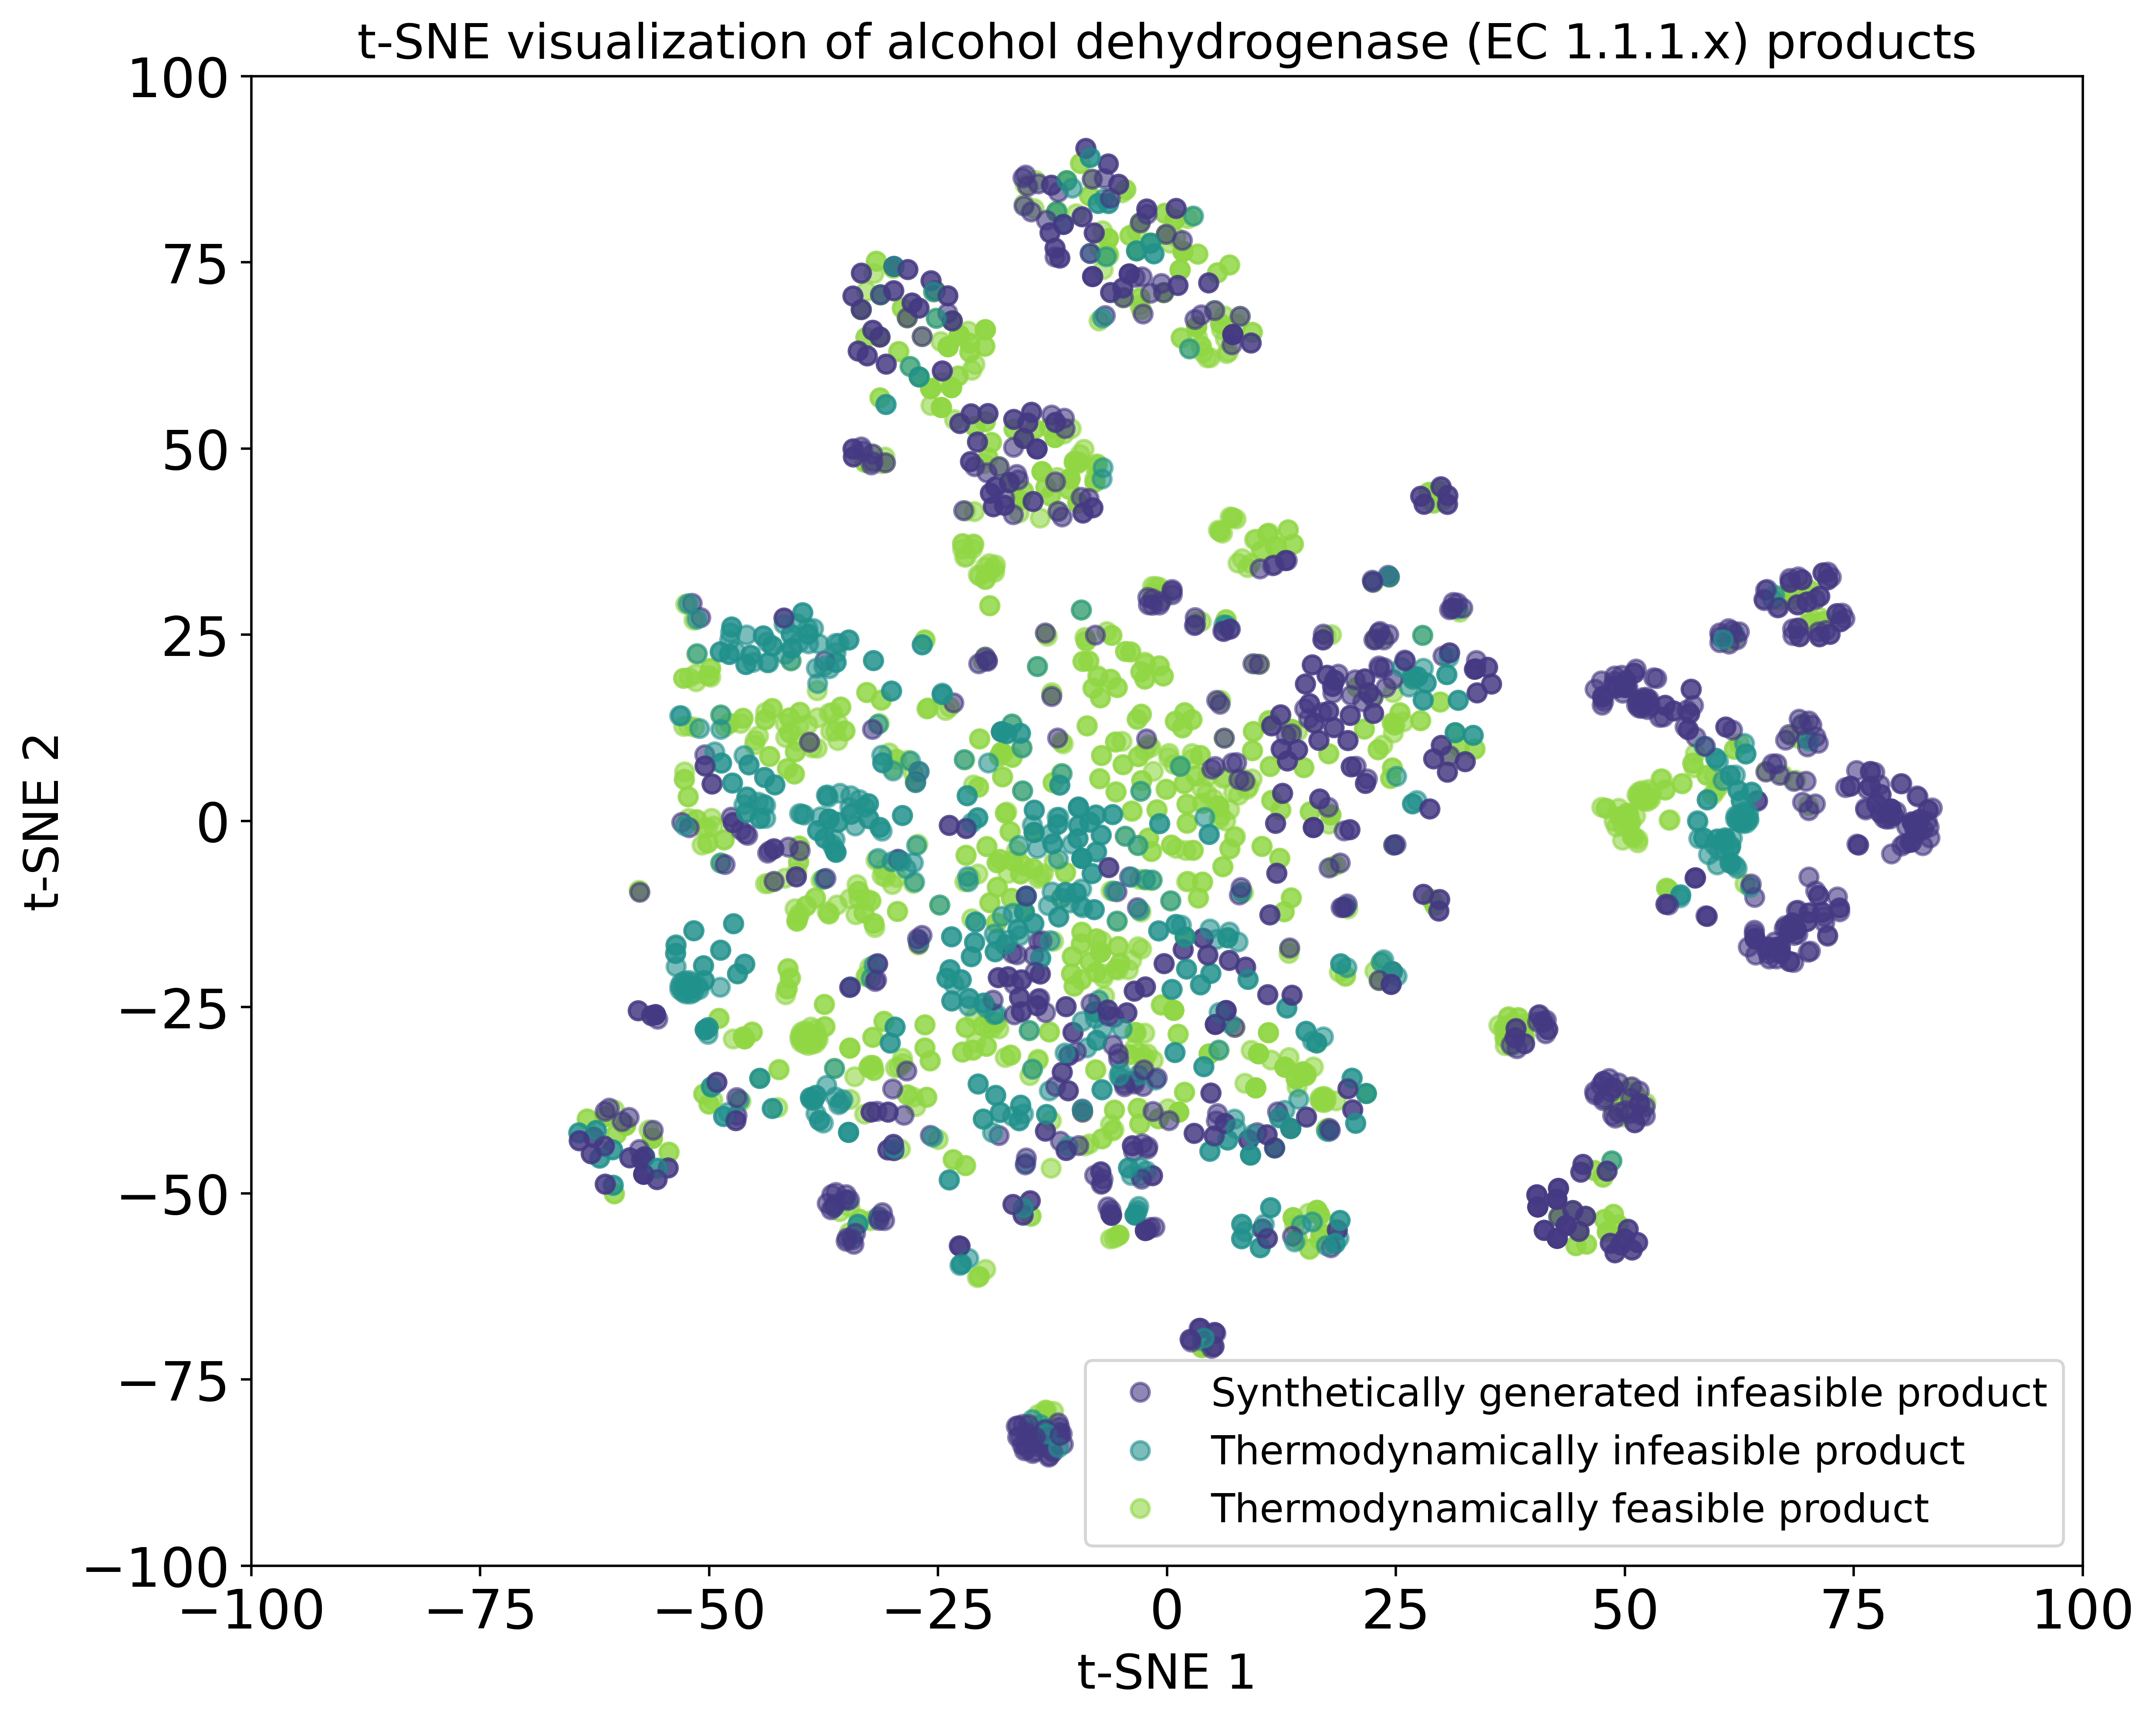

In [12]:
# Plotting

plt.figure(figsize=(10, 8))

scatter = plt.scatter(product_embeddings[:, 0], 
                      product_embeddings[:, 1], 
                      c = int_labels, 
                      cmap='viridis', 
                      alpha=0.6)

plt.clim(-0.5, len(unique_labels) - 0.5)
plt.title('t-SNE visualization of alcohol dehydrogenase (EC 1.1.1.x) products',fontsize = 16)
plt.xlabel('t-SNE 1',fontsize = 16)
plt.ylabel('t-SNE 2',fontsize = 16)
plt.grid(False)

# Adding legend with label names
handles, _ = scatter.legend_elements()

# For the legend, we are going to spell out each of the unique labels printed in the cell above
# this will hopefully make the plot more comprehensible to the reader rather than using shorthand
legend_labels = ['Synthetically generated infeasible product',
                 'Thermodynamically infeasible product',
                 'Thermodynamically feasible product']

plt.legend(handles, legend_labels, fontsize = 13)

plt.xlim([-100,100])
plt.ylim([-100,100])
plt.savefig('SI_fig4A.png')
plt.show()

### <a id="section_2"></a>2. Visualizing the counts of each type of reaction across all 1224 generalizd reaction rules

Here, we explore the distribution of each category of the three categories of reactions across a range of reaction rules

First, we look at an example of how our helper function `get_rxn_counts` can help extract the number of thermodynamically feasible reactions mapped to a single reaction rule (`num_thermo_feasible_rxns`), the number of thermodynamically infeasible reactions mapped to the same rule (`num_thermo_infeasible_rxns`), as well as the number of synthetically generated infeasible reactions mapped to the same rule (`num_generated_neg_rxns`)

In [13]:
query_rule = 'rule0126'
num_generated_neg_rxns,num_thermo_infeasible_rxns,num_thermo_feasible_rxns = get_rxn_counts(all_rxns_df,query_rule)

In [14]:
print(f"\nNumber of thermodynamically feasible reactions under {query_rule}: {num_thermo_feasible_rxns}")
print(f"\nNumber of thermodynamically infeasble reactions under {query_rule}: {num_thermo_infeasible_rxns}")
print(f"\nNumber of synthetically generated negative reactions under {query_rule}: {num_generated_neg_rxns}")

print(f"\nTotal reactions under {query_rule}: {num_thermo_feasible_rxns + num_thermo_infeasible_rxns + num_generated_neg_rxns}")


Number of thermodynamically feasible reactions under rule0126: 16

Number of thermodynamically infeasble reactions under rule0126: 0

Number of synthetically generated negative reactions under rule0126: 4164

Total reactions under rule0126: 4180


Now that we have explored how our helper function `get_rxn_counts` can help in extracting the counts of each reaction type under a simple rule, we turn to exploring the counts of each reaction type under all generalized reaction rules in `JN1224MIN`.

In [15]:
query_rules = list(pd.read_csv('../../data/raw/JN1224MIN_rules.tsv',delimiter='\t')['Name'])

# Initializing lists to hold the counts
thermo_feasible_rxn_counts = []
thermo_infeasible_rxn_counts = []
generated_neg_rxn_counts = []

# Loop through each query rule and get the counts of each reaction type
for rule in query_rules:
    num_generated_neg_rxns, num_thermo_infeasible_rxns, num_thermo_feasible_rxns = get_rxn_counts(all_rxns_df, rule)
    
    thermo_feasible_rxn_counts.append(num_thermo_feasible_rxns)
    thermo_infeasible_rxn_counts.append(num_thermo_infeasible_rxns)
    generated_neg_rxn_counts.append(num_generated_neg_rxns)

# Convert to numpy arrays for easy stacking in the plot
thermo_feasible_rxn_counts = np.array(thermo_feasible_rxn_counts)
thermo_infeasible_rxn_counts = np.array(thermo_infeasible_rxn_counts)
generated_neg_rxn_counts = np.array(generated_neg_rxn_counts)

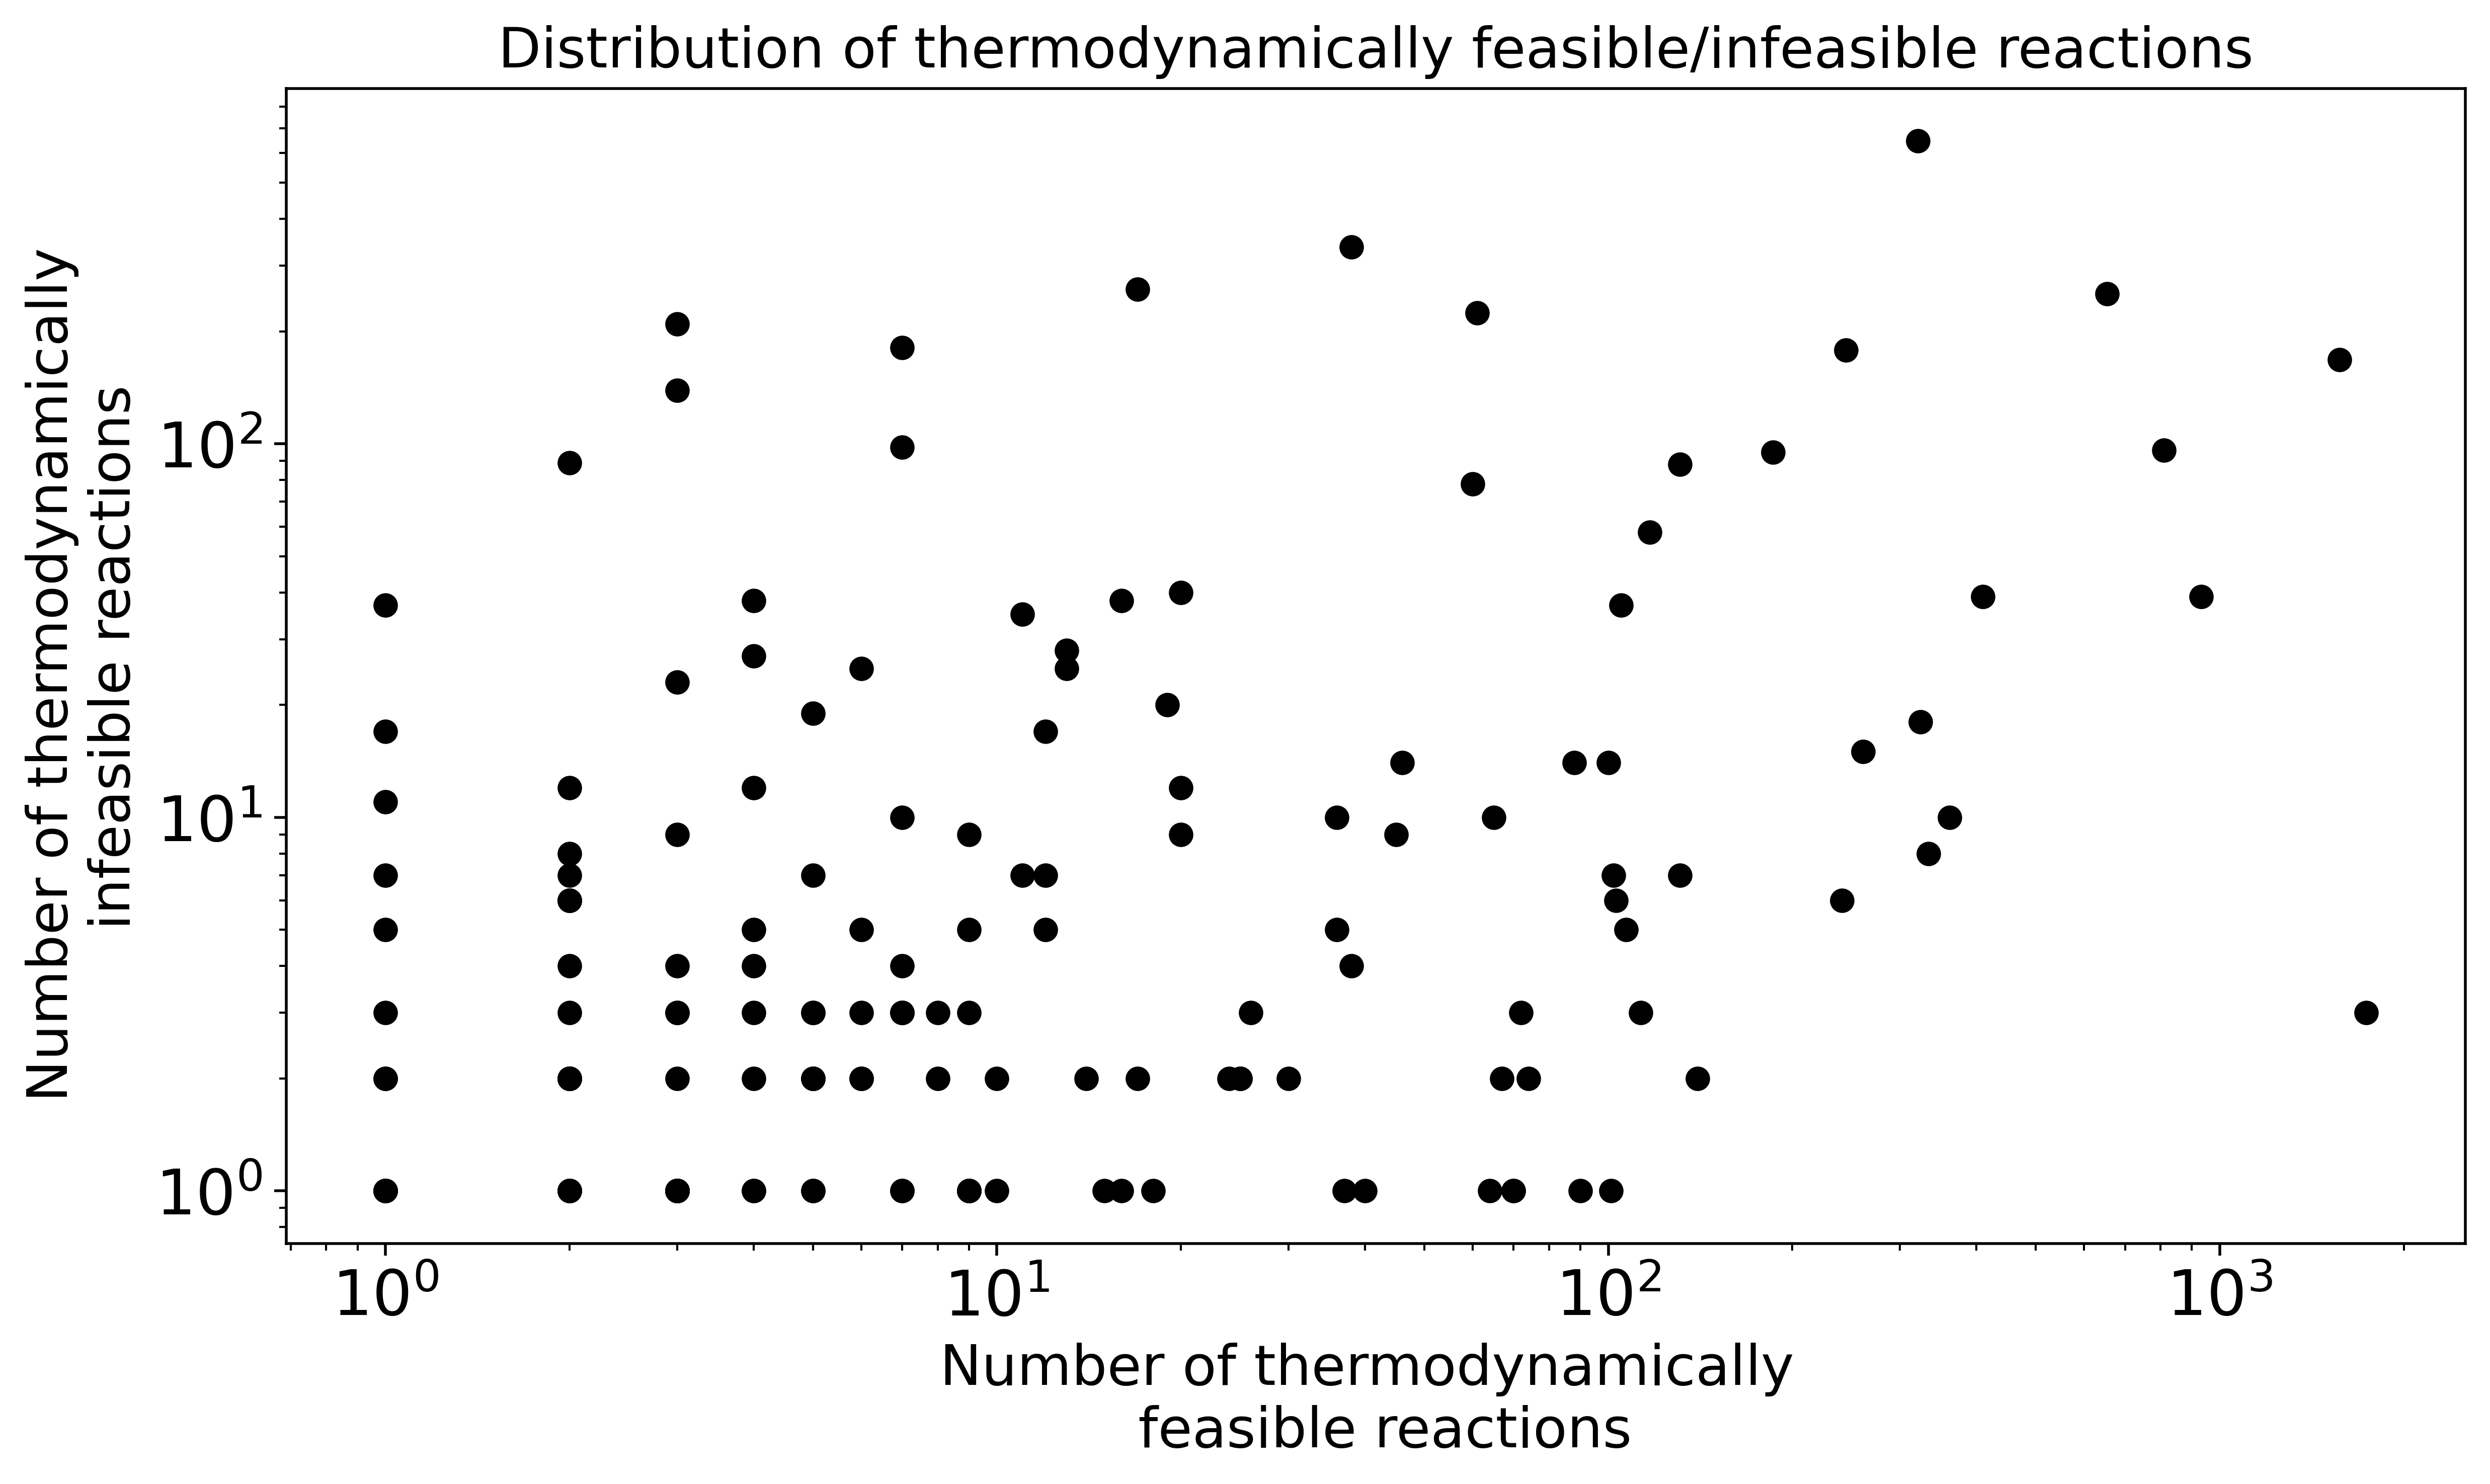

In [16]:
plt.figure(figsize=(10, 6))

# Create a scatter plot
plt.scatter(x = thermo_feasible_rxn_counts, y = thermo_infeasible_rxn_counts, color = 'k')

# Set the scale of x and y axes to log
plt.xscale('log')
plt.yscale('log')

# Set the axis labels
plt.xlabel('Number of thermodynamically \n feasible reactions', fontsize = 16)
plt.ylabel('Number of thermodynamically \n infeasible reactions', fontsize = 16)

# Set a title
plt.title('Distribution of thermodynamically feasible/infeasible reactions',fontsize = 16)

# Show the plot
plt.savefig('SI_fig4B.png')
plt.show()

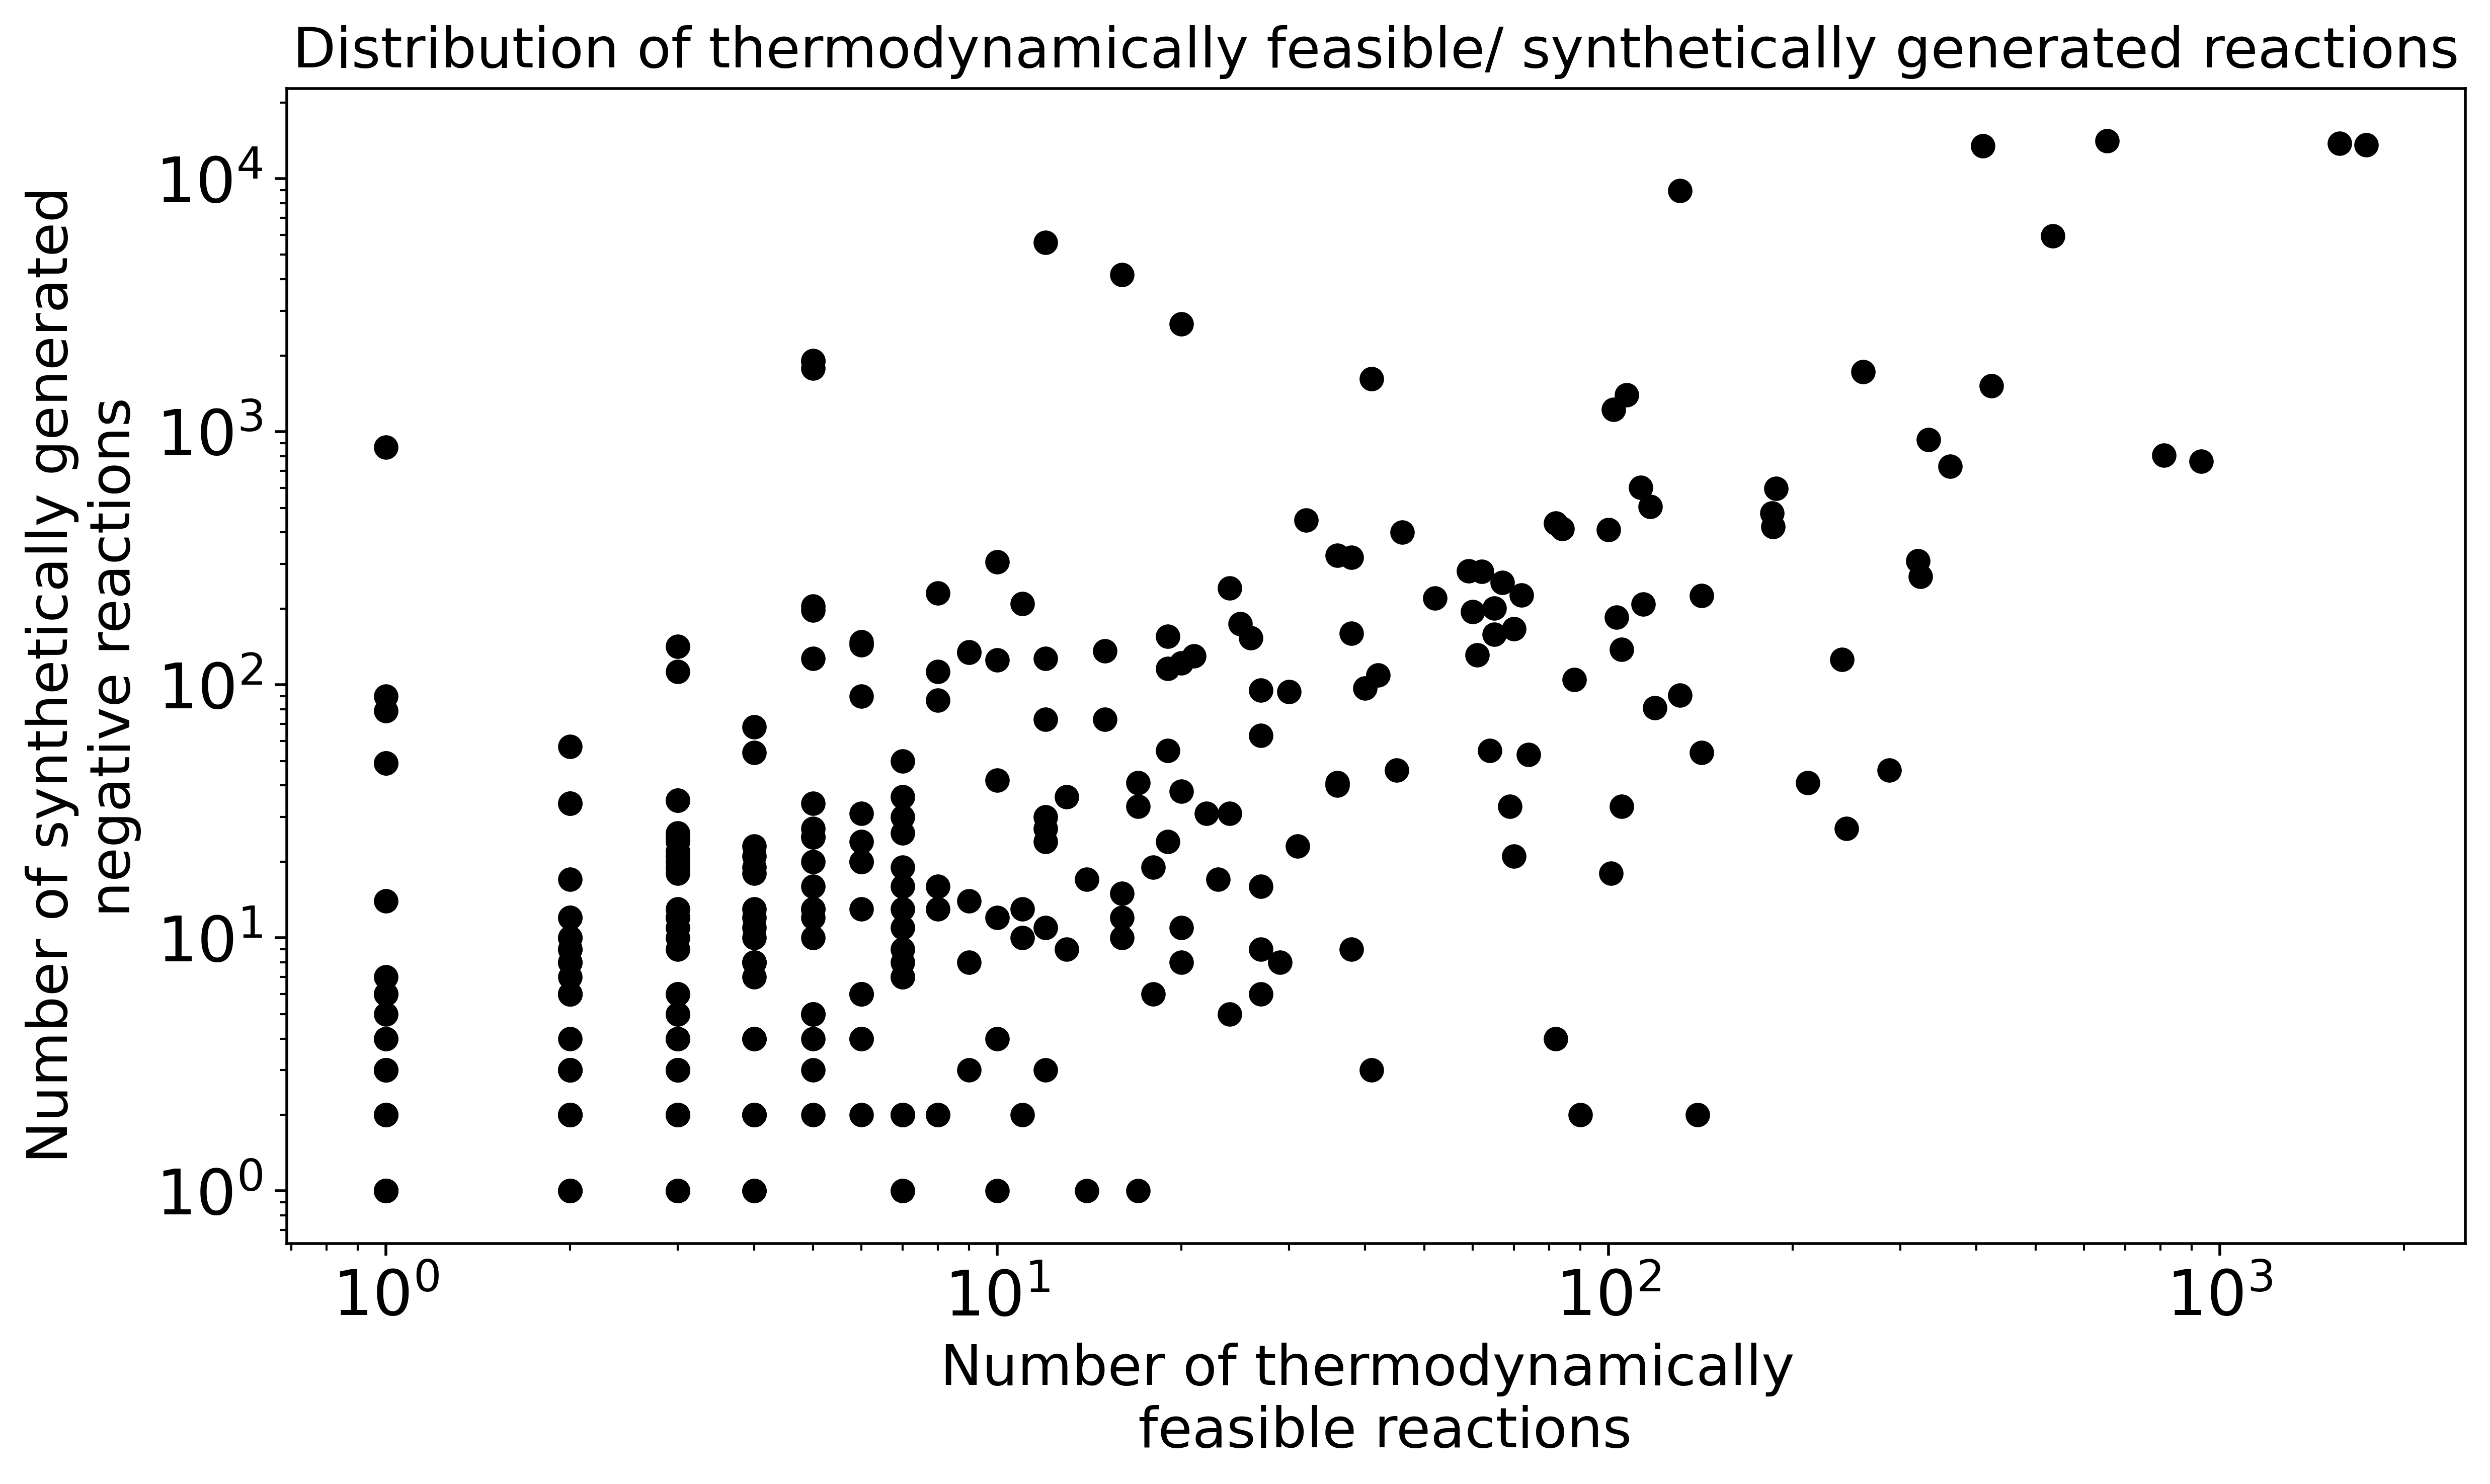

In [17]:
plt.figure(figsize=(10, 6))

# Create a scatter plot
plt.scatter(x = thermo_feasible_rxn_counts, y = generated_neg_rxn_counts, color = 'k')

# Set the scale of x and y axes to log
plt.xscale('log')
plt.yscale('log')

# Set the axis labels
plt.xlabel('Number of thermodynamically \n feasible reactions',fontsize = 16)
plt.ylabel('Number of synthetically generated \n negative reactions',fontsize = 16)

# Set a title
plt.title('Distribution of thermodynamically feasible/ synthetically generated reactions',fontsize = 16)

# Show the plot
plt.savefig('SI_fig4C.png')
plt.show()

We print the length of the list of values in the lists `thermo_feasible_rxn_counts`, `thermo_infeasible_rxn_counts`, and `generated_neg_rxn_counts`. We do this to ensure that each list has 1224 elements since there are 1224 generalized reaction rules under JN1224MIN.

In [18]:
print(f"\nLength of list of thermodynamically feasible reactions: {len(thermo_feasible_rxn_counts)}")
print(f"\nLength of list of thermodynamically infeasible reactions: {len(thermo_infeasible_rxn_counts)}")
print(f"\nLength of list of synthetically generated negative reactions: {len(generated_neg_rxn_counts)}")


Length of list of thermodynamically feasible reactions: 1224

Length of list of thermodynamically infeasible reactions: 1224

Length of list of synthetically generated negative reactions: 1224


Observe the number of thermodynamically feasible reactions for the first 12 reaction rules. The fifth element in this list is 0 because it corresponds to `rule0005`, which is an extremely uphill reverse monooxygenation reaction. The tenth and eleventh elements in this list are also 0 because they correspond to `rule0010` and `rule0011`, respectively, which are SAM/SAH methyltransferase reactions for which we cannot calculate reaction dG with high certainty and thus, dG values were never computed for those reactions

In [19]:
thermo_feasible_rxn_counts[0:12]

array([ 410,  321,  933,  533,    0,  654,  810,  245,  423,    0,    0,
       1570])

In [34]:
all_rxns_df

Reaction eq  Label  \
0       CCCCCCCCCCCCCCCCOCC(N)CO + Nc1ncnc2c1ncn2C1OC(...      1   
1       CC(C)=CCNc1ncnc2c1ncn2C1OC(COP(=O)(O)O)C(O)C1O...      1   
2       CCC=CCC=CCC=CCC=CCC=CCC=CCCC(=O)OC(COC(=O)CCCC...      1   
3       Nc1ccn(C2CSC(COP(=O)(O)O)O2)c(=O)n1 + Nc1ncnc2...      1   
4       NC(N)=NCCCC(N)C(=O)O + NC(Cc1ccc(O)cc1)C(=O)O ...      1   
...                                                   ...    ...   
139210  CC(=O)O + NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)...      0   
139211  CCC(C)C(NC(=O)CNC(=O)C(CO)NC(=O)C(C)NC(=O)CNC(...      0   
139212  CC(C)=CCOc1ccc(C=CC(=O)O)cc1O + O=P(O)(O)OP(=O...      0   
139213  CC(C)=CCCC(C)=CC=CC(C)=CC=CC(C)=CC=CC=C(C)C=CC...      0   
139214  CC(C)=CCCC(C)=CC=CC(C)=CC=CC(C)=CC=CC=C(C)C=CC...      0   

              Reaction ID      Rule                         Remarks  
0             2.7.1.91_06  rule0015               pos rxn by thermo  
1                  R08069  rule0016               pos rxn by thermo  
2             3.1.1.32_05  rule0007               pos rxn by thermo  
3             2.7.4.14_22  rule0015               pos rxn by thermo  
4            6.3.2.49_131  rule0050               pos rxn by thermo  
...                   ...       ...                             ...  
139210  RXN0-3962_reverse  rule0025               neg rxn by thermo  
139211       3.4.23.52_10  rule0013  alternate product from pos rxn  
139212       2.5.1.111_10  rule0431               neg rxn by thermo  
139213  RXN-12001_reverse  rule0198  alternate product from pos rxn  
139214   RXN-8038_reverse  rule0198  alternate product from pos rxn  

[139215 rows x 5 columns]

### <a id="section_3"></a>3. Manually inspecting the synthetically generated negative reactions

Thus far, we have inspected the distributions of each reaction category as well as the chemical space of each product category from a high-level, macro perspective. In order to be really able to ensure that our synthetically generated negative reactions make sense under our alternate reaction center hypothesis, we need to be able to manually inspect our reactions.

#### Manually inspecting alcohol dehydrogenase reactions

We begin by printing the reaction IDs of all **thermodynamically feasible** reported alcohol dehydrogenase reactions that have been mapped to `rule0002`. We chose thermodynamically feasible reactions because only these reactions are used to synthetically generate negative reactions. Reported reactions that were found to be thermodynamically infeasible are lumped with the synthetically generated negative reactions and these reactions are labelled as negative overall

In [20]:
rule2_df = all_rxns_df[all_rxns_df['Rule']=='rule0002']
rule2_pos_rxn_IDs = list(rule2_df[rule2_df['Remarks']=='pos rxn by thermo']['Reaction ID'])

In [21]:
rule2_pos_rxn_IDs

['7-ALPHA-HYDROXYSTEROID-DEH-RXN_reverse',
 '1.1.1.213_31',
 '4-HYDROXYBUTYRATE-DEHYDROGENASE-RXN_reverse',
 '1.1.1.188_06',
 'DIHYDROKAEMPFEROL-4-REDUCTASE-RXN_reverse',
 '1.1.1.395_5',
 'R03176',
 'R04837',
 '1.1.1.1_116',
 'RXN-9389_reverse',
 'RXN66-314',
 '1.1.1.334_0',
 '1.1.1.356 ()_2',
 'RXN-17404_reverse',
 '1.1.1.117-RXN',
 'GDP-6-DEOXY-D-TALOSE-4-DEHYDROGENASE-RXN_reverse',
 'RXN66-24',
 'L-RHAMNOSE-1-DEHYDROGENASE-RXN_reverse',
 'R03583',
 '1.1.1.356 ()_3',
 '1.1.1.118_01',
 '1.1.1.239_45',
 'RXN-17571_reverse',
 '1.1.1.252_03',
 'R04758',
 'R06472_reverse',
 'R03292',
 '9-FLUORENOL-DEHYDROGENASE-RXN',
 '1.1.1.112_33',
 'R04836',
 'RXN-12131_reverse',
 '1.1.1.21_08',
 '1.1.1.252_16',
 'RXN-9796_reverse',
 '1.1.1.230-RXN_reverse',
 '1.1.1.361_2',
 '1.1.1.119_01',
 'RXN-16169',
 '1.1.1.53-RXN_reverse',
 'RXN-14668_reverse',
 'RXN-11470',
 'BENZYL-ALCOHOL-DEHYDROGENASE-RXN_reverse',
 '1.1.1.213_68',
 '1.1.1.328_05',
 'RXN66-353_reverse',
 'RXN-14358',
 'INDANOL-DEHYDROGENASE-R

From the list of reaction IDs of thermodynamically feasible reactions that were mapped to `rule0002`, let's randomy select a few for which we can inspect the corresponding alternate reactions. `rule0002` involves the oxidation of an alcohol group to a carbonyl so this inspection works best for substrates with multiple alcohol groups. If you happen to come across a reaction where you would expect alternate products but do not happen to see them, don't panic as it may be the case that these alternate products were in fact generated the first time but were subsequently removed when we began eliminating duplicates because these alternate products may have also been generated again from another reaction.

Let's pick: `1.1.1.188_06`, `1.1.1.118_01`, `D-XYLOSE-1-DEHYDROGENASE-NADP+-RXN`, `R04840`, `SHIKIMATE-5-DEHYDROGENASE-RXN`, and `1.1.1.47_48`

Examining `1.1.1.188_06`:

In [22]:
rule2_df[rule2_df['Reaction ID']=='1.1.1.188_06']

Reaction eq  Label  \
321     CCCCCC(O)C=CC1C(O)CC(O)C1CC=CCCCC(=O)NCCO + NC...      1   
38082   CCCCCC(O)C=CC1C(O)CC(O)C1CC=CCCCC(=O)NCCO + NC...      0   
64582   CCCCCC(O)C=CC1C(O)CC(O)C1CC=CCCCC(=O)NCCO + NC...      0   
138906  CCCCCC(O)C=CC1C(O)CC(O)C1CC=CCCCC(=O)NCCO + NC...      0   

         Reaction ID      Rule                         Remarks  
321     1.1.1.188_06  rule0002               pos rxn by thermo  
38082   1.1.1.188_06  rule0002  alternate product from pos rxn  
64582   1.1.1.188_06  rule0002  alternate product from pos rxn  
138906  1.1.1.188_06  rule0002  alternate product from pos rxn

In [23]:
list(rule2_df[rule2_df['Reaction ID']=='1.1.1.188_06']['Reaction eq'])

['CCCCCC(O)C=CC1C(O)CC(O)C1CC=CCCCC(=O)NCCO + NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1 = CCCCCC(O)C=CC1C(=O)CC(O)C1CC=CCCCC(=O)NCCO + NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)C=CC1',
 'CCCCCC(O)C=CC1C(O)CC(O)C1CC=CCCCC(=O)NCCO + NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1 = CCCCCC(=O)C=CC1C(O)CC(O)C1CC=CCCCC(=O)NCCO + NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)C=CC1',
 'CCCCCC(O)C=CC1C(O)CC(O)C1CC=CCCCC(=O)NCCO + NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1 = CCCCCC(O)C=CC1C(O)CC(O)C1CC=CCCCC(=O)NCC=O + NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)C=CC1',
 'CCCCCC(O)C=CC1C(O)CC(O)C1CC=CCCCC(=O)NCCO + NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1 = CCCCCC(O)C=CC1C(O)CC(=O)C1

Examining `1.1.1.118_01`:

In [24]:
rule2_df[rule2_df['Reaction ID']=='1.1.1.118_01']

Reaction eq  Label   Reaction ID  \
1140   OCC1OC(O)CC(O)C1O + NC(=O)c1ccc[n+](C2OC(COP(=...      1  1.1.1.118_01   
39136  OCC1OC(O)CC(O)C1O + NC(=O)c1ccc[n+](C2OC(COP(=...      0  1.1.1.118_01   
85498  OCC1OC(O)CC(O)C1O + NC(=O)c1ccc[n+](C2OC(COP(=...      0  1.1.1.118_01   
92816  OCC1OC(O)CC(O)C1O + NC(=O)c1ccc[n+](C2OC(COP(=...      0  1.1.1.118_01   

           Rule                         Remarks  
1140   rule0002               pos rxn by thermo  
39136  rule0002  alternate product from pos rxn  
85498  rule0002  alternate product from pos rxn  
92816  rule0002  alternate product from pos rxn

In [25]:
list(rule2_df[rule2_df['Reaction ID']=='1.1.1.118_01']['Reaction eq'])

['OCC1OC(O)CC(O)C1O + NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1 = O=C1CC(O)C(O)C(CO)O1 + NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1',
 'OCC1OC(O)CC(O)C1O + NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1 = O=CC1OC(O)CC(O)C1O + NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1',
 'OCC1OC(O)CC(O)C1O + NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1 = O=C1C(O)CC(O)OC1CO + NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1',
 'OCC1OC(O)CC(O)C1O + NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1 = O=C1CC(O)OC(CO)C1O + NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1']

Examining `D-XYLOSE-1-DEHYDROGENASE-NADP+-RXN`:

In [26]:
rule2_df[rule2_df['Reaction ID']=='D-XYLOSE-1-DEHYDROGENASE-NADP+-RXN']

Reaction eq  Label  \
9415   OC1COC(O)C(O)C1O + NC(=O)c1ccc[n+](C2OC(COP(=O...      1   
28487  OC1COC(O)C(O)C1O + NC(=O)c1ccc[n+](C2OC(COP(=O...      0   
78992  OC1COC(O)C(O)C1O + NC(=O)c1ccc[n+](C2OC(COP(=O...      0   
95461  OC1COC(O)C(O)C1O + NC(=O)c1ccc[n+](C2OC(COP(=O...      0   

                              Reaction ID      Rule  \
9415   D-XYLOSE-1-DEHYDROGENASE-NADP+-RXN  rule0002   
28487  D-XYLOSE-1-DEHYDROGENASE-NADP+-RXN  rule0002   
78992  D-XYLOSE-1-DEHYDROGENASE-NADP+-RXN  rule0002   
95461  D-XYLOSE-1-DEHYDROGENASE-NADP+-RXN  rule0002   

                              Remarks  
9415                pos rxn by thermo  
28487  alternate product from pos rxn  
78992  alternate product from pos rxn  
95461  alternate product from pos rxn

In [27]:
list(rule2_df[rule2_df['Reaction ID']=='D-XYLOSE-1-DEHYDROGENASE-NADP+-RXN']['Reaction eq'])

['OC1COC(O)C(O)C1O + NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1 = O=C1OCC(O)C(O)C1O + NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)C=CC1',
 'OC1COC(O)C(O)C1O + NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1 = O=C1C(O)OCC(O)C1O + NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)C=CC1',
 'OC1COC(O)C(O)C1O + NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1 = O=C1C(O)COC(O)C1O + NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)C=CC1',
 'OC1COC(O)C(O)C1O + NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1 = O=C1COC(O)C(O)C1O + NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)C=CC1']

Examining `R04840`

In [28]:
rule2_df[rule2_df['Reaction ID']=='R04840']

Reaction eq  Label Reaction ID  \
11897   CC12CC(O)C3C(CCC4CC(O)CCC43C)C1CCC2C(=O)CO + N...      1      R04840   
117284  CC12CC(O)C3C(CCC4CC(O)CCC43C)C1CCC2C(=O)CO + N...      0      R04840   

            Rule                         Remarks  
11897   rule0002               pos rxn by thermo  
117284  rule0002  alternate product from pos rxn

In [29]:
list(rule2_df[rule2_df['Reaction ID']=='R04840']['Reaction eq'])

['CC12CC(O)C3C(CCC4CC(O)CCC43C)C1CCC2C(=O)CO + NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1 = CC12CC(=O)C3C(CCC4CC(O)CCC43C)C1CCC2C(=O)CO + NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)C=CC1',
 'CC12CC(O)C3C(CCC4CC(O)CCC43C)C1CCC2C(=O)CO + NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1 = CC12CC(O)C3C(CCC4CC(O)CCC43C)C1CCC2C(=O)C=O + NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)C=CC1']

Examining `SHIKIMATE-5-DEHYDROGENASE-RXN`

In [30]:
rule2_df[rule2_df['Reaction ID']=='SHIKIMATE-5-DEHYDROGENASE-RXN']

Reaction eq  Label  \
15437  O=C(O)C1=CC(O)C(O)C(O)C1 + NC(=O)c1ccc[n+](C2O...      1   
49727  O=C(O)C1=CC(O)C(O)C(O)C1 + NC(=O)c1ccc[n+](C2O...      0   
72922  O=C(O)C1=CC(O)C(O)C(O)C1 + NC(=O)c1ccc[n+](C2O...      0   

                         Reaction ID      Rule                         Remarks  
15437  SHIKIMATE-5-DEHYDROGENASE-RXN  rule0002               pos rxn by thermo  
49727  SHIKIMATE-5-DEHYDROGENASE-RXN  rule0002  alternate product from pos rxn  
72922  SHIKIMATE-5-DEHYDROGENASE-RXN  rule0002  alternate product from pos rxn

In [31]:
list(rule2_df[rule2_df['Reaction ID']=='SHIKIMATE-5-DEHYDROGENASE-RXN']['Reaction eq'])

['O=C(O)C1=CC(O)C(O)C(O)C1 + NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1 = O=C(O)C1=CC(=O)C(O)C(O)C1 + NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)C=CC1',
 'O=C(O)C1=CC(O)C(O)C(O)C1 + NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1 = O=C(O)C1=CC(O)C(=O)C(O)C1 + NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)C=CC1',
 'O=C(O)C1=CC(O)C(O)C(O)C1 + NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1 = O=C(O)C1=CC(O)C(O)C(=O)C1 + NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)C=CC1']

Examining `1.1.1.47_48`

In [32]:
rule2_df[rule2_df['Reaction ID']=='1.1.1.47_48']

Reaction eq  Label  Reaction ID  \
16402   OCC1OC(OC2C(CO)OC(O)C(O)C2O)C(O)C(O)C1O + NC(=...      1  1.1.1.47_48   
53022   OCC1OC(OC2C(CO)OC(O)C(O)C2O)C(O)C(O)C1O + NC(=...      0  1.1.1.47_48   
62013   OCC1OC(OC2C(CO)OC(O)C(O)C2O)C(O)C(O)C1O + NC(=...      0  1.1.1.47_48   
90295   OCC1OC(OC2C(CO)OC(O)C(O)C2O)C(O)C(O)C1O + NC(=...      0  1.1.1.47_48   
106264  OCC1OC(OC2C(CO)OC(O)C(O)C2O)C(O)C(O)C1O + NC(=...      0  1.1.1.47_48   
113456  OCC1OC(OC2C(CO)OC(O)C(O)C2O)C(O)C(O)C1O + NC(=...      0  1.1.1.47_48   
113713  OCC1OC(OC2C(CO)OC(O)C(O)C2O)C(O)C(O)C1O + NC(=...      0  1.1.1.47_48   
122268  OCC1OC(OC2C(CO)OC(O)C(O)C2O)C(O)C(O)C1O + NC(=...      0  1.1.1.47_48   

            Rule                         Remarks  
16402   rule0002               pos rxn by thermo  
53022   rule0002  alternate product from pos rxn  
62013   rule0002  alternate product from pos rxn  
90295   rule0002  alternate product from pos rxn  
106264  rule0002  alternate product from pos rxn  
113456  rule0002  alternate product from pos rxn  
113713  rule0002  alternate product from pos rxn  
122268  rule0002  alternate product from pos rxn

In [33]:
list(rule2_df[rule2_df['Reaction ID']=='1.1.1.47_48']['Reaction eq'])

['OCC1OC(OC2C(CO)OC(O)C(O)C2O)C(O)C(O)C1O + NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1 = O=C1OC(CO)C(OC2OC(CO)C(O)C(O)C2O)C(O)C1O + NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1',
 'OCC1OC(OC2C(CO)OC(O)C(O)C2O)C(O)C(O)C1O + NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1 = O=C1C(O)C(O)OC(CO)C1OC1OC(CO)C(O)C(O)C1O + NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1',
 'OCC1OC(OC2C(CO)OC(O)C(O)C2O)C(O)C(O)C1O + NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1 = O=C1C(OC2C(CO)OC(O)C(O)C2O)OC(CO)C(O)C1O + NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1',
 'OCC1OC(OC2C(CO)OC(O)C(O)C2O)C(O)C(O)C1O + NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1 = O=C1C(CO)OC(OC2C(CO)OC(O)C(O)C2O)C(O)C1O + NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)